## Package and data import


Requires the following packages: <br>
spektral <br>
tensorflow <br>
networkx <br>
matplotlib <br>
numpy <br>
pandas <br>

In [ ]:
import sys
!{sys.executable} -m pip install spektral
!{sys.executable} -m pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 14.8 MB/s 


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data import Dataset
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import itertools
import pandas as pd
from spektral.data import PackedBatchLoader, BatchLoader
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalSumPool
from spektral.transforms.normalize_adj import NormalizeAdj

2022-08-05 12:02:22.311306: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-05 12:02:22.314231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 12:02:22.314239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
path_48 = "../datasets/DatasetB.csv"
data_48 =  pd.read_csv(path_48)

data = data_48
data

,ID,x,y,z,fate,range
0,0,-3.696736,-0.106814,-1.368457,1.0,0.909722
1,0,-1.501985,-4.388962,2.201270,1.0,0.909722
2,0,-1.063584,2.670580,-3.888227,1.0,0.909722
3,0,-0.885980,2.163211,3.621143,1.0,0.909722
4,0,2.707704,-3.552179,-1.088195,1.0,0.909722
...,...,...,...,...,...,...
10556452,9999,2.471484,-4.978401,-1.474982,1.0,0.107458
10556453,9999,-4.722823,2.954911,1.842062,0.0,0.107458
10556454,9999,-4.065723,1.276151,0.152383,0.0,0.107458
10556455,9999,1.265246,-0.583105,5.049639,0.0,0.107458


## Data conversion to graph

In [ ]:

def filter_organoids(org_data):
  fateprops = []
  ranges = []
  res = []
  maxi = max(org_data["ID"])
  organoids = [org_data[org_data["ID"] == i] for i in range(maxi)]
  for org in organoids:
    org = org.reset_index() 
    fate0count = fate1count = 0
    for i in range(len(org)):
      if int(org["fate"].iloc[i]) == 0:
        fate0count += 1
      else:
        fate1count += 1
    if fate0count and fate1count: 
      fateprop = fate0count/fate1count
      if fateprop > 1/2 and fateprop < 2:
        res.append(org)
        fateprops.append(fateprop)
  return res, fateprops

def to_xy(organoids):
  xys = []
  for org in organoids:
    xys.append(org[["x", "y", "z"]].to_numpy())
  return xys
  
def to_fate(organoids):
  fate = []
  for org in organoids:
    fate.append(org["fate"].to_numpy())
  return fate

def to_range(organoids):
  ranges = []
  for org in organoids:
    ranges.append(org["range"].iloc[0])
  return ranges

In [ ]:
def create_graph(xy):
  G = nx.Graph()
  dist = cdist(xy, xy)
  tri = Delaunay(xy)
  for i in range(len(xy)):
    G.add_node(i)

  r = 1
  for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
      if dist[path[0],path[1]] < 2*r:
            G.add_edge(path[0], path[1], weight = dist[path[0],path[1]])
            
  return G

In [ ]:
filtered, fateprops = filter_organoids(data)
xys, fates, ranges = to_xy(filtered), to_fate(filtered), to_range(filtered)
print("Number of organoids: ", len(filtered))
print("Max q, min q, max nCells, min nCells: ", max(ranges), min(ranges), max([len(f) for f in filtered]) , min([len(f) for f in filtered]))

3287
0.9991490388200952 5.868959566612819e-05 1401 612


## Creation of dataset and loaders

In [ ]:
class OrgDataset(Dataset):
  def __init__(self, **kwargs):
    #self.feats = 1

    super().__init__(**kwargs)
  
  def read(self):
    output = []
    for xy, fate, __range in zip(xys, fates, ranges):
      G = create_graph(xy)
      a = nx.convert_matrix.to_scipy_sparse_matrix(G)
      output.append(
            Graph(x=fate, a=a, y=__range)
        )
    return output

In [ ]:
batch_size = 10
domask = False
dataset = OrgDataset()

# Train/valid/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = dataset[idx_tr]
data_va = dataset[idx_va]
data_te = dataset[idx_te]

# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size = batch_size)
loader_va = DisjointLoader(data_va, batch_size = batch_size)
loader_te = DisjointLoader(data_te, batch_size = batch_size)

print(len(data_te))


/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (1025, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (952, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (927, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (1171, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (1073, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was au

329


## Model creation and training

In [ ]:
from spektral.layers import GCSConv
from spektral.layers import SRCPool, GlobalAttentionPool, GlobalAttnSumPool
#vorher war gscconv

def get_callbacks():
  return [
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor = 0.2)  ]
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(450, activation="relu")
        self.conv2 = GCSConv(150, activation="sigmoid")
        self.global_pool = GlobalAttnSumPool()
        self.dense1 = Dense(50, activation="relu")
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense2 = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = inputs[0]
        a = inputs[1]
        i = inputs[2]
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.flatten1(output)
        output = self.dense2(output)

        return output

model = Net()

optimizer = Adam(lr=0.005)
loss_fn = MeanSquaredError()

model.compile(optimizer, loss_fn)
model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, validation_data = loader_va.load(), validation_steps = loader_va.steps_per_epoch, verbose = 1, epochs= 30, callbacks = get_callbacks())

#
model.save("Model1.3D")



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/net/global_attn_sum_pool/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/net/global_attn_sum_pool/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/net/global_attn_sum_pool/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/net/global_attn_sum_pool/Reshape_4:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/net/global_attn_sum_pool/Reshape_3:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/net/global_attn_sum_pool/Cast_1:0", sha

263/263 [==============================] - 97s 359ms/step - loss: 0.0333 - val_loss: 0.0249 - lr: 0.0050
Epoch 2/30
263/263 [==============================] - 94s 357ms/step - loss: 0.0126 - val_loss: 0.0056 - lr: 0.0050
Epoch 3/30
263/263 [==============================] - 94s 357ms/step - loss: 0.0056 - val_loss: 0.0031 - lr: 0.0050
Epoch 4/30
263/263 [==============================] - 94s 356ms/step - loss: 0.0050 - val_loss: 0.0038 - lr: 0.0050
Epoch 5/30
263/263 [==============================] - 94s 357ms/step - loss: 0.0058 - val_loss: 0.0032 - lr: 0.0050
Epoch 6/30
263/263 [==============================] - 94s 358ms/step - loss: 0.0043 - val_loss: 0.0025 - lr: 0.0050
Epoch 7/30
263/263 [==============================] - 94s 359ms/step - loss: 0.0042 - val_loss: 0.0025 - lr: 0.0050
Epoch 8/30
263/263 [==============================] - 95s 360ms/step - loss: 0.0041 - val_loss: 0.0034 - lr: 0.0050
Epoch 9/30
263/263 [==============================] - 95s 361ms/step - loss: 0.0041

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/disjoint_largedata_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/disjoint_largedata_model/assets


## Model testing

In [ ]:
#model = tf.keras.models.load_model("Model1.3D")


In [ ]:
preds_all = np.array([])
targets_all = np.array([])
for i in range(20):

  input, target = loader_te.__next__()
  preds = model.predict_on_batch(input)
  preds_all = np.append(preds_all, preds.reshape(10,), axis = 0)
  targets_all = np.append(targets_all, target.reshape(10,), axis = 0)



/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'OrgDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


[[0.5034634 ]
 [0.51921046]
 [0.15281609]
 [0.09210646]
 [0.8414694 ]
 [0.8932851 ]
 [0.6086373 ]
 [0.8433975 ]
 [0.24992242]
 [0.7976148 ]]


(200, 1) (200,)
MSE: 0.0026456586375218226
10


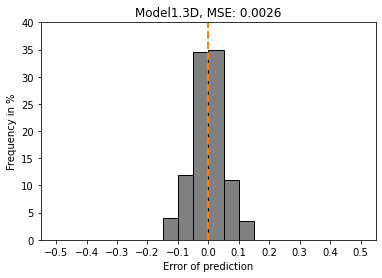

In [ ]:
predictions_np = np.array([round(0.05*round(elem/0.05), 2) for elem in preds_all]).reshape(200,1)
print(predictions_np.shape, targets_all.shape)

def plot_er_hist(errors):
  bin = np.arange(-0.5, 0.55, 0.05)
  plt.hist(errors, bins = bin, density=False, weights=(np.zeros_like(errors) + 1. / errors.size)*100, facecolor="grey", edgecolor="black")
  plt.xticks(bin[::2])
  plt.yticks(range(0, 45, 5))
  plt.axvline(0, color='C1', linestyle='dashed', linewidth=2)
  plt.xlabel("Error of prediction")
  plt.ylabel("Frequency in %")

plot_er_hist((predictions_np - targets_all.reshape(200, 1)))
print("MSE:", np.mean((targets_all.reshape(200, 1)-predictions_np)**2))
print(len(preds))
plt.title("Model1.3D, MSE: " +  str(round(np.mean((targets_all.reshape(200, 1)-predictions_np)**2), 4)))
plt.savefig("../figures/GNNmodelHist_largedata.jpg", dpi = 300)

## Loading of in vitro data and creating dataset and loaders, then predicting in vitro organoids


In [ ]:
iv_path = "../datasets/DatasetE.csv"
iv_data = pd.read_csv(iv_path)


def to_xyz(organoids):
  xys = []
  for org in organoids:
    xys.append(org[["CentroidX", "CentroidY", "CentroidZ"]].to_numpy())
    #yield org[["x", "y"]].to_numpy()
  return xys
  
def to_fate_iv(organoids, fatekind = "KM"):
  #need to handle GM 2 fate
  fate = []
  for org in organoids:
    #yield org["fate"].to_numpy()
    fate.append(org["Fate_" + fatekind + "_Cluster"].to_numpy())
  return fate

def create_graph_iv(xy):
  G = nx.Graph()
  dist = cdist(xy, xy)
  tri = Delaunay(xy)
  for i in range(len(xy)):
    G.add_node(i)
  
  all_dist = []
  for i in range(len(xy)):
    neigh = tri.vertex_neighbor_vertices[1][tri.vertex_neighbor_vertices[0][i]:tri.vertex_neighbor_vertices[0][i+1]]
    for j in neigh:
      all_dist.append(dist[i,j])
  cutoff = np.mean(all_dist) + 2*np.std(all_dist)
  
  for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
      if dist[path[0],path[1]] < cutoff:
          G.add_edge(path[0], path[1], weight = dist[path[0],path[1]] /(0.5 * cutoff))
  return G

organoids = [iv_data[iv_data["OrganoidID"] == i] for i in range(1,max(iv_data["OrganoidID"]) + 1)]
xyzs = to_xyz(organoids)
fates_iv = to_fate_iv(organoids)

class PredDataset(Dataset):
  def __init__(self, **kwargs):
    #self.nodes = 150
    #self.feats = 1

    super().__init__(**kwargs)
  
  def read(self):
    output = []
    for xy, fate in zip(xyzs, fates_iv):
      G = create_graph_iv(xy)
      a = nx.convert_matrix.to_scipy_sparse_matrix(G)
      output.append(
            Graph(x=fate.astype("float64"), a=a, y = -1)
        )
    return output

dataset_iv = PredDataset()
loader_iv = DisjointLoader(dataset_iv, batch_size = 10)

input = loader_iv.__next__()

iv_preds = model.predict(loader_iv.load(), steps = loader_iv.steps_per_epoch)


results = pd.read_csv("E_result_template.csv")
results["disjoint_preds_largedata"] = iv_preds


/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (693, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (687, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (636, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (646, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (679, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")
/usr/local/lib/python3.7/dist-packages/spektral/data/graph.py:67: UserWarning: x was autom

[[0.25502655]
 [0.20627666]
 [0.35339537]
 [0.02287406]
 [0.01543361]
 [0.02376062]
 [0.12891549]
 [0.12156016]
 [0.17589357]
 [0.36514428]
 [0.03562799]
 [0.03619534]
 [0.04214078]
 [0.24915555]
 [0.36615974]
 [0.17774469]
 [0.42575893]
 [0.36080462]
 [0.30135462]
 [0.20944247]
 [0.19351614]
 [0.2390176 ]
 [0.03482646]
 [0.05080491]
 [0.30762464]
 [0.2840718 ]
 [0.38682237]
 [0.34611833]
 [0.10829043]
 [0.13285452]
 [0.03822199]
 [0.06755856]
 [0.25390825]
 [0.44623622]
 [0.01205593]
 [0.14459205]
 [0.30924237]
 [0.07305968]
 [0.27528757]
 [0.03666839]
 [0.4147738 ]
 [0.4307412 ]
 [0.04404444]
 [0.22873914]
 [0.32350457]
 [0.3234328 ]
 [0.06772479]
 [0.21936044]
 [0.14052185]
 [0.38486886]
 [0.22538334]
 [0.27361584]
 [0.13614151]
 [0.46976888]
 [0.2311661 ]
 [0.3812976 ]
 [0.22970262]
 [0.41041726]
 [0.3678895 ]
 [0.29341513]
 [0.3079722 ]
 [0.14863291]
 [0.18183896]
 [0.2843196 ]
 [0.19134656]
 [0.06930757]
 [0.36514428]
 [0.06755856]
 [0.04214078]
 [0.03562799]
 [0.18183896]
 [0.19

In [ ]:
results.to_csv("../datasets/DatasetE_predicted.csv")

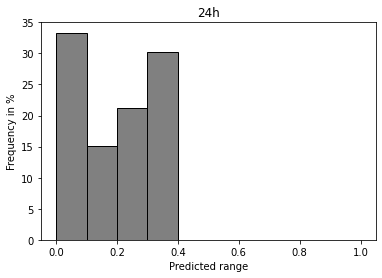

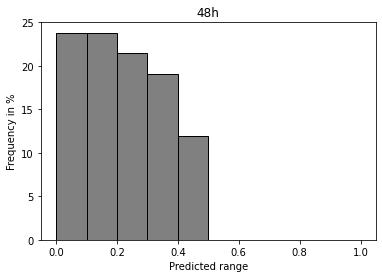

In [ ]:
h24 = results[results["Stage"] == "24h"]
h48 = results[results["Stage"] == "48h"]
data = h24["disjoint_preds_largedata"]
bin = np.arange(0, 1.1, 0.1)
plt.hist(data, bins = bin, density=False, weights=(np.zeros_like(data) + 1. / data.size)*100, facecolor="grey", edgecolor="black")
plt.xticks(bin[::2])
plt.xlabel("Predicted range")
plt.ylabel("Frequency in %")
plt.title("24h")
plt.savefig("../figures/preds24.jpg", dpi = 300)

plt.figure()
data = h48["disjoint_preds_largedata"]
bin = np.arange(0, 1.1, 0.1)
plt.hist(data, bins = bin, density=False, weights=(np.zeros_like(data) + 1. / data.size)*100, facecolor="grey", edgecolor="black")
plt.xticks(bin[::2])
plt.xlabel("Predicted range")
plt.ylabel("Frequency in %")
plt.title("48h")
plt.savefig("../figures/preds48.jpg", dpi = 300)

